In [1]:
pip install tensorflow keras numpy matplotlib opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:

dataset_full_path='/kaggle/input/edges2shoes-dataset'
train_folder = os.path.join(dataset_full_path, "train")
eval_folder = os.path.join(dataset_full_path, "val")


In [35]:
from glob import glob

train_images = glob(os.path.join(train_folder, "*.jpg"))  # Adjust extension as needed
eval_images = glob(os.path.join(eval_folder, "*.jpg"))
print(len(train_images))
train_images = train_images[:2000]  # Use only the first 500 images
eval_images = eval_images[:100]
print("length",len(train_images))

49825
length 2000


In [36]:

IMG_HEIGHT, IMG_WIDTH = 256, 256


def load_and_preprocess_image_pair(image_path):
    # Split the input and target (example assumes images are concatenated horizontally)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)  # Or decode_png depending on format

    # Example for splitting paired images (adjust splitting logic as needed)
    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]

    # Preprocess both images
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH])
    input_image = (input_image / 127.5) - 1  # Normalize to [-1, 1]

    target_image = tf.image.resize(target_image, [IMG_HEIGHT, IMG_WIDTH])
    target_image = (target_image / 127.5) - 1  # Normalize to [-1, 1]

    return input_image, target_image

# Update the dataset mapping
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.map(load_and_preprocess_image_pair).batch(16).shuffle(1000)

eval_dataset = tf.data.Dataset.from_tensor_slices(eval_images)
eval_dataset = eval_dataset.map(load_and_preprocess_image_pair).batch(16)
   # Use only the first 100 images



In [37]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, ReLU, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras import Model

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

def build_generator():
    inputs = Input(shape=[256, 256, 3])

    # Downsampling layers
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Upsampling layers
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),   # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                           kernel_initializer=initializer, activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []

    # Downsampling
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)


In [38]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    input_image = Input(shape=[256, 256, 3], name='input_image')
    target_image = Input(shape=[256, 256, 3], name='target_image')

    x = Concatenate()([input_image, target_image])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)    # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)    # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                   kernel_initializer=initializer,
                                   use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return Model(inputs=[input_image, target_image], outputs=last)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_36       │ (None, 128, 128,  │      6,144 │ concatenate_16[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_37       │ (None, 64, 64,    │    131,584 │ sequential_36[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_38       │ (None, 32, 32,    │    525,312 │ sequential_37[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 34, 34,    │          0 │ sequential_38[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_4… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 33, 33,    │          0 │ leaky_re_lu_27[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [39]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)


In [40]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + fake_loss


In [41]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [42]:
generator = build_generator()
generator.summary()  # Optional: To verify the model architecture


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_39       │ (None, 128, 128,  │      3,072 │ input_layer_41[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_40       │ (None, 64, 64,    │    131,584 │ sequential_39[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_41       │ (None, 32, 32,    │    525,312 │ sequential_40[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_42       │ (None, 16, 16,    │  2,099,200 │ sequential_41[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_43       │ (None, 8, 8, 512) │  4,196,352 │ sequential_42[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_44       │ (None, 4, 4, 512) │  4,196,352 │ sequential_43[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_45       │ (None, 2, 2, 512) │  4,196,352 │ sequential_44[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_46       │ (None, 1, 1, 512) │  4,196,352 │ sequential_45[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_47       │ (None, 2, 2, 512) │  4,196,352 │ sequential_46[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 2, 2,      │          0 │ sequential_47[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_45[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_48       │ (None, 4, 4, 512) │  8,390,656 │ concatenate_17[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 4, 4,      │          0 │ sequential_48[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_44[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_49       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 8, 8,      │          0 │ sequential_49[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_50       │ (None, 16, 16,    │  8,390,656 │ concatenate_19[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 16, 16,    │          0 │ sequential_50[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [43]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [44]:
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for input_image, target in train_dataset:
        train_step(input_image, target)
    #if epoch == 0 :  
        #prediction = generator(input_image, training=False)
        #print("Prediction:", prediction.numpy())




Epoch 1/100


2024-11-25 09:21:53.672843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_65_1/sequential_47_1/dropout_6_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

In [45]:
def generate_images(model, input_image, target):
    prediction = model(input_image, training=False)
    plt.figure(figsize=(15, 5))

    display_list = [input_image[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()


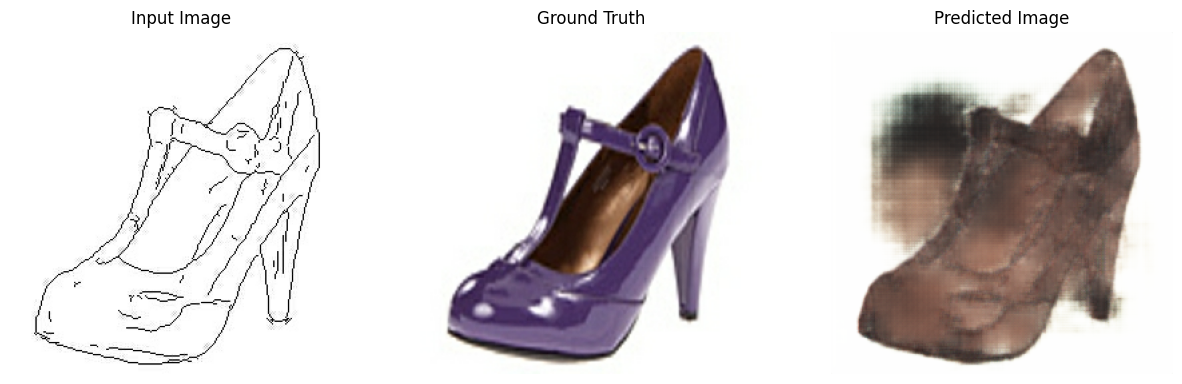

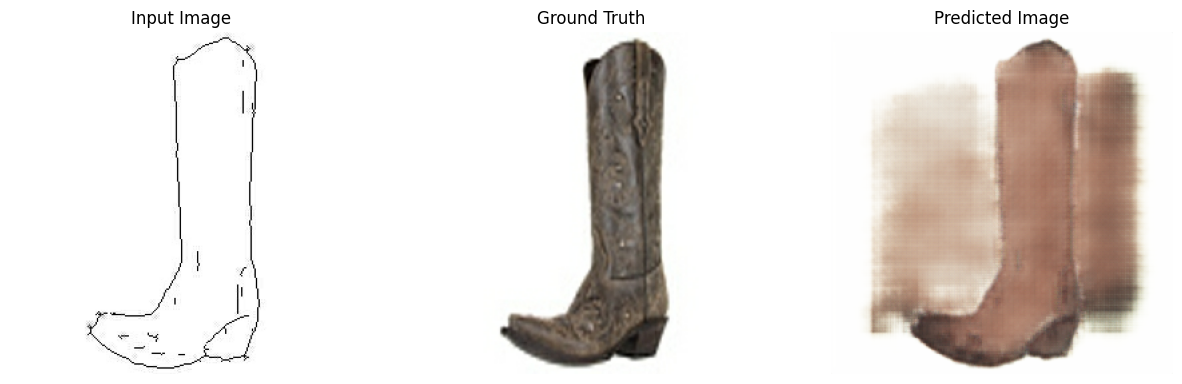

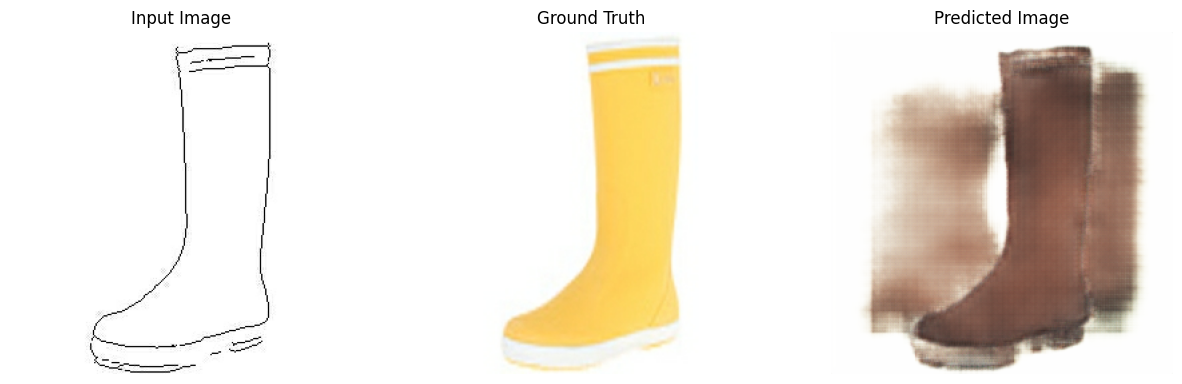

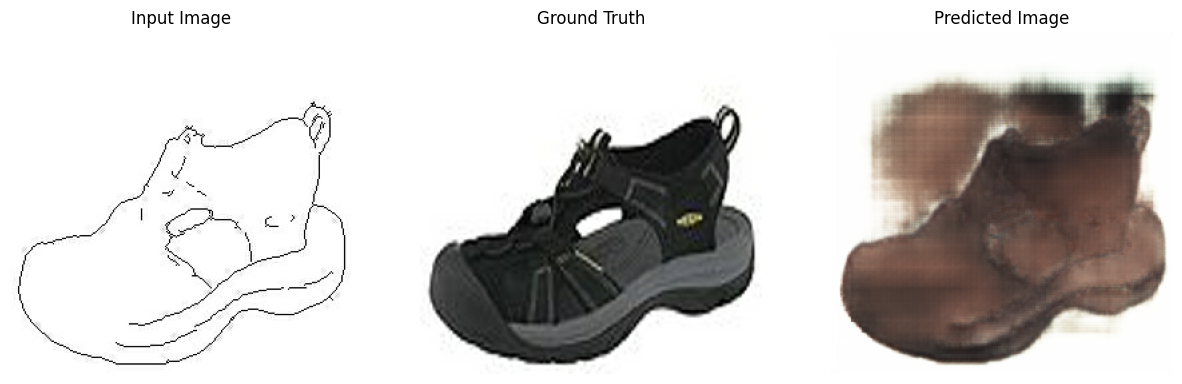

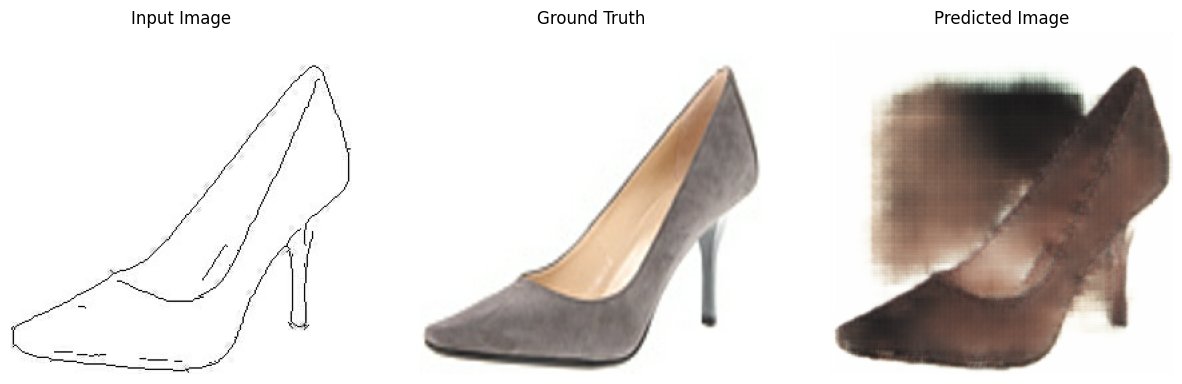

In [46]:
for input_image, target in eval_dataset.take(5):  # Display predictions for 5 images
    generate_images(generator, input_image, target)


In [47]:
generator.save('pix2pix_generator.h5')
